# feature engineering

### setup

In [20]:
THRESHOLD=0.2
PROP=1/100

#configure for local mimic databse
exec(open("../configs/configure_mimic.py").read())
exec(open("my_functions.py").read())


Configured for local MIMIC database:
	user = postgres
	dbname = mimic
	host = localhost
	schema_name = mimiciii
	query_schema = SET search_path to mimiciii;


## demographics
From admissions and patients tables

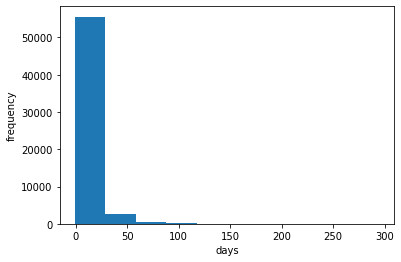

In [21]:
#load admission data along with outcomes desginated in build_outcome.ipynb
adat = pd.read_csv('/Users/grovesdixon/projects/Insight/icu_project/my_mimic/outcome_penalizable_dat.csv')

#add stay duration
adat['stay_duration'] = pd.to_datetime(adat['dischtime']) - pd.to_datetime(adat['admittime'])
adat['stay_duration'] = pd.to_timedelta(adat['stay_duration'], unit='D')/datetime.timedelta(days=1)
plt.hist(adat['stay_duration'])
plt.xlabel('days')
plt.ylabel('frequency');

#subset for useful variables and remove patients with deathtimes
adat = adat.loc[adat['deathtime'].isna(), ['subject_id', 'hadm_id', 'admittime', 'discharge_location', 'insurance', 'language', 'religion',
       'marital_status', 'ethnicity', 'hospital_expire_flag', 'stay_duration', 'hrrd_penalized']]

In [22]:
#load patient data
query = query_schema + \
"""select 
    subject_id,
    gender,
    dob
    from patients"""
pdat = pd.read_sql_query(query,con)

#merge them
odat = pd.merge(adat, pdat, how = 'inner', on='subject_id')
odat['dob_dt'] = pd.to_datetime(odat['dob']).dt.date
odat['admittime_dt'] = pd.to_datetime(odat['admittime']).dt.date
odat['age'] = odat.apply(lambda e: (e['admittime_dt'] - e['dob_dt']).days/365, axis=1)
odat.loc[odat['age']>200, 'age'] = 91
odat = odat.loc[odat['age']>18, ['subject_id', 'hadm_id', 'hrrd_penalized', 'discharge_location', 'insurance',
       'language', 'religion', 'marital_status', 'ethnicity',
       'gender', 'age']]
odat.index = odat['hadm_id']
odat.drop(columns = ['hadm_id', 'subject_id'])

,hrrd_penalized,discharge_location,insurance,language,religion,marital_status,ethnicity,gender,age
hadm_id,,,,,,,,,
165315,0,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,F,64.969863
152223,0,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,M,71.178082
124321,0,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,M,75.304110
161859,0,HOME,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,M,39.041096
129635,0,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,M,58.989041
...,...,...,...,...,...,...,...,...,...
141860,0,SNF,Medicare,ENGL,CATHOLIC,WIDOWED,WHITE,F,80.389041
187987,0,HOME HEALTH CARE,Private,ENGL,NOT SPECIFIED,MARRIED,WHITE,M,53.613699
190603,0,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,M,78.326027


#### handle missing values

In [23]:
# print(np.sum(odat.isnull()))
odat.loc[odat['language'].isna(), 'language'] = 'missing'
odat.loc[odat['religion'].isna(), 'religion'] = 'missing'
odat.loc[odat['marital_status'].isna(), 'marital_status'] = 'missing'
# print(np.sum(odat.isnull()))

#### age distribution

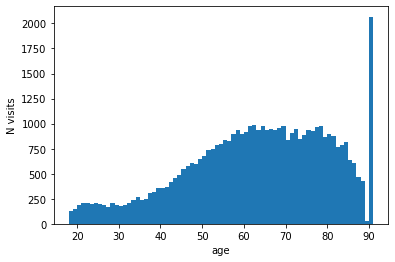

In [24]:
plt.hist(odat['age'], bins = 91-18);
plt.xlabel('age')
plt.ylabel('N visits')
plt.show();

### add icu features
add total time spent in icu and total icu visits

/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


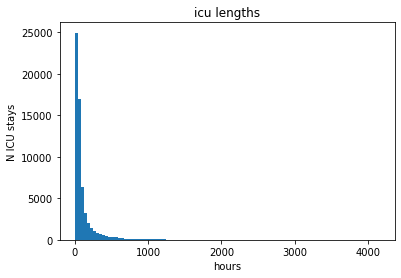

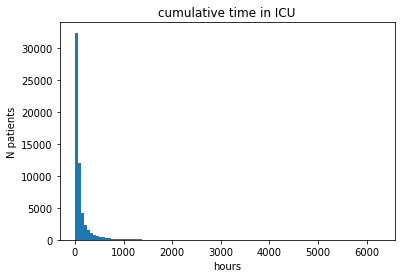

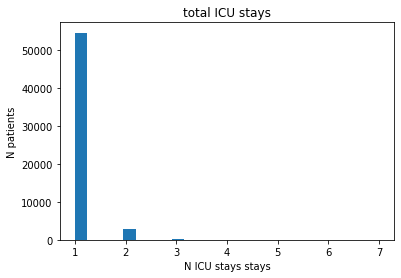

In [25]:
#load patient data
query = query_schema + \
"""select 
    *
    from ICUSTAYS"""
idat = pd.read_sql_query(query,con)



idat['icu_duration'] = idat['outtime'] - idat['intime']
idat['icu_duration'] = pd.to_timedelta(idat['icu_duration'], unit='hr')/datetime.timedelta(hours=1)

#plot icu hours
plt.hist(idat['icu_duration'], bins=100)
plt.title('icu lengths')
plt.xlabel('hours')
plt.ylabel('N ICU stays')
plt.show()

#organize icu stay features
total_time = idat.loc[:,['icu_duration', 'hadm_id']].groupby(['hadm_id']).sum()
total_icu_visits = idat.loc[:,['hadm_id', 'icustay_id']].groupby(['hadm_id']).count()
total_icu_visits.columns = ['nicu_stays']
total_icu_visits.index.name = 'hadm_id'
icu_features = pd.merge(total_time, total_icu_visits, how='inner', on='hadm_id')

#plot cumulative icu time
plt.hist(icu_features['icu_duration'], bins=100)
plt.title('cumulative time in ICU')
plt.xlabel('hours')
plt.ylabel('N patients')
plt.show()

#plot total ICU stays
plt.hist(icu_features['nicu_stays'], bins=25)
plt.title('total ICU stays')
plt.xlabel('N ICU stays stays')
plt.ylabel('N patients')
plt.show()

#add to odat
odat = pd.merge(odat.drop(columns='hadm_id'), icu_features, how = 'inner', on = 'hadm_id')

In [26]:
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split
odat['hadm_id'] = odat.index
y = odat['hrrd_penalized']
X = odat.drop([
    'hrrd_penalized'], 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=321, stratify=y)
print(np.sum(y_train))
print(np.sum(y_test))
all_hadm_ids = odat['hadm_id']
train_hadm_ids = X_train['hadm_id']
test_hadm_ids = X_test['hadm_id']
train_pos_hadm_ids = train_hadm_ids[y==1]
len(train_pos_hadm_ids)
X_train.drop(['subject_id', 'hadm_id'], 1)
X_test.drop(['subject_id', 'hadm_id'], 1)

860
215


,discharge_location,insurance,language,religion,marital_status,ethnicity,gender,age,icu_duration,nicu_stays
hadm_id,,,,,,,,,,
188876,HOME HEALTH CARE,Medicare,ENGL,NOT SPECIFIED,MARRIED,WHITE,M,69.775342,23.028333,1
199278,HOME HEALTH CARE,Medicare,ENGL,JEWISH,MARRIED,WHITE,M,85.046575,50.030000,1
197579,LONG TERM CARE HOSPITAL,Private,ENGL,PROTESTANT QUAKER,SINGLE,WHITE,M,37.958904,25.070000,1
158308,LONG TERM CARE HOSPITAL,Private,ENGL,NOT SPECIFIED,MARRIED,WHITE,F,60.210959,19.257222,1
138446,REHAB/DISTINCT PART HOSP,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,M,80.350685,26.722778,1
...,...,...,...,...,...,...,...,...,...,...
148004,REHAB/DISTINCT PART HOSP,Private,ENGL,CATHOLIC,DIVORCED,WHITE,F,37.663014,42.599444,1
134188,HOME HEALTH CARE,Private,ENGL,CATHOLIC,MARRIED,WHITE,M,53.591781,123.397500,1
180393,SNF,Medicare,*YID,JEWISH,MARRIED,WHITE,M,91.000000,55.757222,2


## add presence absence features

In [27]:
def filter_by_presence_in_pos(input_df, pos_ids, feature_col, prop=1/50):
    """Function to remove features unlikely to be informative for outcome.
    df = the input predictors
    pos_ids = the positive hadm_ids
    feature_col = the column of features (eg prescriptions, diagnoses, procedures) given to patient
    prop = the proportion of positive patients the feature must have occured in to keep it"""
    pos_df = input_df.loc[input_df['hadm_id'].isin(pos_ids),]
    occurance = pos_df[feature_col].value_counts()
    keep_features = occurance.index[occurance > (len(pos_ids)*prop)]
    print('{} features found among >= {}% of positive cases'.format(len(keep_features), prop*100))
    return input_df.loc[input_df[feature_col].isin(keep_features),:]


def filter_by_presence_in_general(input_df, feature_col, prop=1/100):
    """Function to remove features unlikely to be informative for outcome because rare in dataset.
    input_df = the input predictors
    feature_col = the column of features (eg prescriptions, diagnoses, procedures) given to patient
    prop = the proportion of hadm_ids the feature must have occured in to keep it"""
    occurance = input_df[feature_col].value_counts()
    keep_features = occurance.index[occurance > (len(input_df['hadm_id'].unique())*prop)]
    print('{} features found among >= {}% of positive cases'.format(len(keep_features), prop*100))
    return input_df.loc[input_df[feature_col].isin(keep_features),:]

from sklearn.preprocessing import MinMaxScaler
def onehot_features(long_df, feature_col):
    to_onehot = [feature_col]
    raw_oh_dat = pd.get_dummies(long_df, columns = to_onehot, drop_first = True)
    summed_dat = raw_oh_dat.groupby('hadm_id').sum()
    bool_dat = summed_dat > 0
    oh_dat = bool_dat.astype('int')
    total_col = 'total_{}'.format(feature_col)
    oh_dat[total_col] = oh_dat.sum(axis=1)
    scaler = MinMaxScaler()
    oh_dat[[total_col]] = scaler.fit_transform(oh_dat[[total_col]])
    return oh_dat

from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
def logistic_select_features(dat, y_train, feature_col, threshold):
    """feature selection using l1 regularization.
    dat = full dataset of features
    y_train = the training outcome data indexed with hadm_id
    The data are subset to match just the test set, then logistic regression coefficient is used for selection"""
    #make sure data and training outputs line up
    dat_for_train = dat.copy()
    dat_ids = set(dat_for_train.index)
    y_ids = set(y_train.index)
    shared_ids = list(dat_ids.intersection(y_ids))
    dat_X_train = dat_for_train.loc[shared_ids,:] #first subset for training set
    dat_y_train = y_train.loc[shared_ids]   #then subset outcomes to match
    matched = np.sum(dat_X_train.index==dat_y_train.index) ==dat_X_train.shape[0]
    print('training data and outcomes matched = {}'.format(matched))
    print('total ids used for training = {}'.format(dat_X_train.shape[0]))
    #do selection
    sel = SelectFromModel(estimator=LogisticRegression(max_iter=1000),
                         threshold = threshold).fit(dat_X_train, dat_y_train)
    coefs = sel.estimator_.coef_
    #write out for prettier plotting
    pd.DataFrame({'coef':coefs[0]}).to_csv('../data/for_plotting/' + feature_col + '_coefs.csv',
                                          index=False)
    #plot the distribution of coefficients
    plt.hist(coefs[0], bins=100)
    plt.xlabel('coeficient')
    plt.ylabel('frequency')
    plt.title('before selection')
    plt.show()
    #plot the distribution of coefficients after selection
    plt.hist(coefs[0][sel.get_support()], bins=100)
    plt.xlabel('coeficient')
    plt.ylabel('frequency')
    plt.title('after selection')
    plt.show()
    #make selections
    print(np.mean(np.absolute(coefs)))
    print('selector threshold = {}'.format(sel.threshold_))
    sel.get_support()
    nonZeroN = np.sum(sel.get_support())
    print('{} total featuers had nonzero coefficients after selection'.format(nonZeroN))
    res = dat.loc[:,list(dat_X_train.columns[sel.get_support()])]
    return res

#function to combine all above
def select_presence_absence_features(input_df, all_ids, train_ids, pos_ids, feature_col, prop, y_train, threshold):
    filt_pos = filter_by_presence_in_pos(input_df, pos_ids, feature_col, prop)
    filt_gen = filter_by_presence_in_general(input_df, feature_col, prop=prop)
    keep = pd.concat([filt_pos, filt_gen], 0)
    filt_df = input_df.loc[input_df[feature_col].isin(keep[feature_col])]
    print('{} features total unique feature kept for selection'.format(len(filt_df[feature_col].unique()), prop*100))
    oh_dat = onehot_features(filt_df, feature_col)
    sel_dat = logistic_select_features(oh_dat, y_train, feature_col, threshold)
    return sel_dat

    
#vars for recording
dat_dict = {'odat': odat}
dat_list = ['odat']

## services

11 features found among >= 1.0% of positive cases
12 features found among >= 1.0% of positive cases
12 features total unique feature kept for selection
training data and outcomes matched = True
total ids used for training = 34743


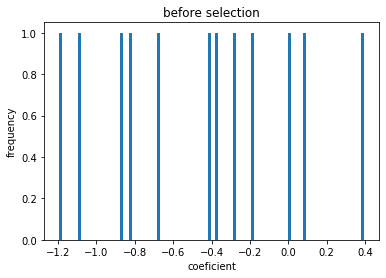

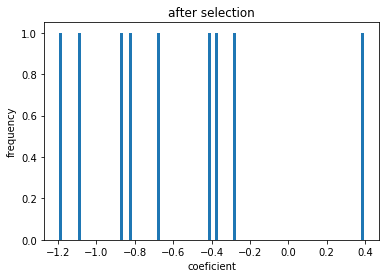

0.5311427997657961
selector threshold = 0.2
9 total featuers had nonzero coefficients after selection


(58029, 9)

In [28]:
#load patient data
query = query_schema + \
"""select 
    hadm_id,
    curr_service
    from SERVICES"""
serv_dat = pd.read_sql_query(query,con)
serv_dat = select_presence_absence_features(input_df = serv_dat,
                                            all_ids = all_hadm_ids,
                                          train_ids = train_hadm_ids,
                                          pos_ids = train_pos_hadm_ids,
                                          feature_col = 'curr_service',
                                          prop=PROP,
                                          y_train = y_train,
                                            threshold=THRESHOLD)
dat_dict['services'] = serv_dat
dat_list.append('services')
serv_dat.shape

### diagnoses

283 features found among >= 1.0% of positive cases
211 features found among >= 1.0% of positive cases
318 features total unique feature kept for selection
training data and outcomes matched = True
total ids used for training = 34398


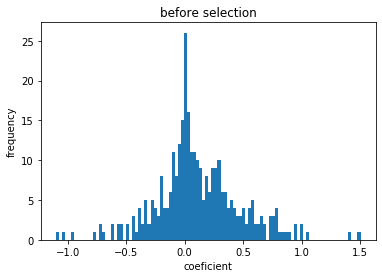

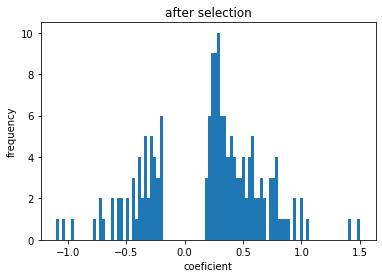

0.2717793541476549
selector threshold = 0.2
163 total featuers had nonzero coefficients after selection


(57830, 163)

In [29]:
#load patient data
query = query_schema + \
"""select 
    hadm_id,
    icd9_code
    from DIAGNOSES_ICD"""
ddat = pd.read_sql_query(query,con)
ddat = ddat.rename(columns = {'icd9_code':'diagnosis_icd9'})
ddat = select_presence_absence_features(input_df = ddat,
                                        all_ids = all_hadm_ids,
                                          train_ids = train_hadm_ids,
                                          pos_ids = train_pos_hadm_ids,
                                          feature_col = 'diagnosis_icd9',
                                          prop=PROP,
                                          y_train = y_train,
                                         threshold=THRESHOLD)
dat_dict['diagnoses'] = ddat
dat_list.append('diagnoses')
ddat.shape

### procedures

64 features found among >= 1.0% of positive cases
72 features found among >= 1.0% of positive cases
79 features total unique feature kept for selection
training data and outcomes matched = True
total ids used for training = 27648


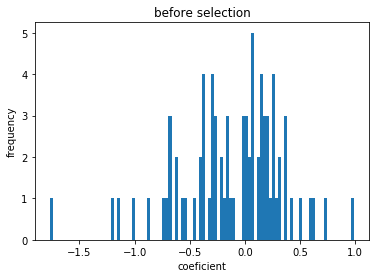

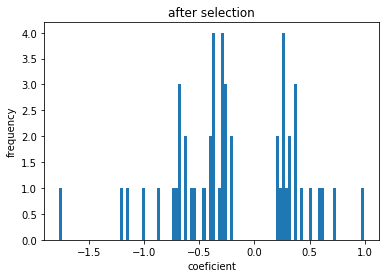

0.3520491756047948
selector threshold = 0.2
50 total featuers had nonzero coefficients after selection


(47857, 50)

In [30]:
#load patient data
query = query_schema + \
"""select 
    hadm_id,
    icd9_code
    from PROCEDURES_ICD"""
proc_dat = pd.read_sql_query(query, con)
proc_dat = proc_dat.rename(columns = {'icd9_code':'procedure_icd9'})
proc_dat = select_presence_absence_features(input_df = proc_dat,
                                            all_ids = all_hadm_ids,
                                          train_ids = train_hadm_ids,
                                          pos_ids = train_pos_hadm_ids,
                                          feature_col = 'procedure_icd9',
                                          prop=PROP,
                                          y_train = y_train,
                                           threshold=THRESHOLD)
dat_dict['procedures'] = proc_dat
dat_list.append('procedures')
proc_dat.shape

### prescriptions

136 features found among >= 10.0% of positive cases
146 features found among >= 10.0% of positive cases
162 features total unique feature kept for selection
training data and outcomes matched = True
total ids used for training = 32355


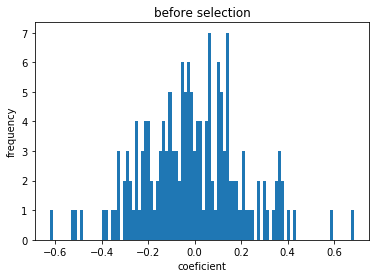

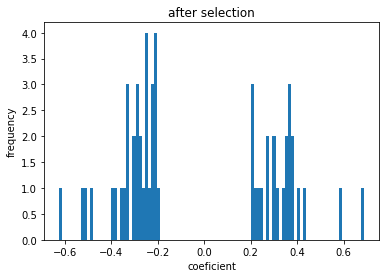

0.1675834110343343
selector threshold = 0.2
55 total featuers had nonzero coefficients after selection


(49856, 55)

In [31]:
#load patient data
query = query_schema + \
"""select 
    hadm_id,
    drug
    from PRESCRIPTIONS"""
drug_dat = pd.read_sql_query(query, con)
drug_dat = select_presence_absence_features(input_df = drug_dat,
                                            all_ids = all_hadm_ids,
                                          train_ids = train_hadm_ids,
                                          pos_ids = train_pos_hadm_ids,
                                          feature_col = 'drug',
                                          prop=1/10,
                                          y_train = y_train,
                                           threshold=THRESHOLD)
dat_dict['drugs'] = drug_dat
dat_list.append('drugs')
drug_dat.shape

### icu wards
Here we get all the ICU wards the pateint was exposed to

5 features found among >= 2.0% of positive cases
6 features found among >= 2.0% of positive cases
6 features total unique feature kept for selection
training data and outcomes matched = True
total ids used for training = 35164


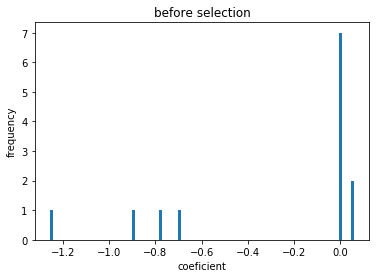

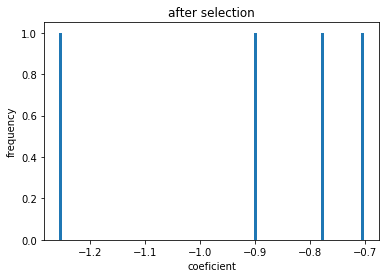

0.28887277848440723
selector threshold = 0.2
4 total featuers had nonzero coefficients after selection
9 features found among >= 2.0% of positive cases
10 features found among >= 2.0% of positive cases
10 features total unique feature kept for selection
training data and outcomes matched = True
total ids used for training = 34925


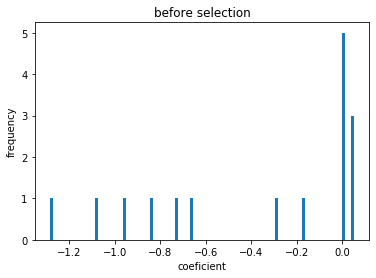

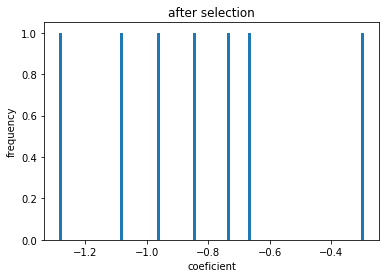

0.38718430873693604
selector threshold = 0.2
7 total featuers had nonzero coefficients after selection


In [32]:
#care unit
careunit_dat = select_presence_absence_features(input_df = idat,
                                            all_ids = all_hadm_ids,
                                          train_ids = train_hadm_ids,
                                          pos_ids = train_pos_hadm_ids,
                                          feature_col = 'last_careunit',
                                          prop=1/50,
                                          y_train = y_train,
                                           threshold=THRESHOLD)
if careunit_dat.shape[0] > 0:
    dat_dict['care_unit'] = careunit_dat
    dat_list.append('care_unit')
    careunit_dat.shape

#ward
ward_dat = select_presence_absence_features(input_df = idat,
                                            all_ids = all_hadm_ids,
                                          train_ids = train_hadm_ids,
                                          pos_ids = train_pos_hadm_ids,
                                          feature_col = 'last_wardid',
                                          prop=1/50,
                                          y_train = y_train,
                                           threshold=THRESHOLD)
if careunit_dat.shape[0] > 0:
    dat_dict['ward'] = ward_dat
    dat_list.append('ward')
    ward_dat.shape

## combine

In [33]:
cdat = odat.copy()
cdat = cdat.drop(columns = ['hadm_id'])

#merge them all
for d in dat_list:
    if d != 'odat':
        to_add = dat_dict[d]
        print(d)
        cdat = pd.merge(cdat, dat_dict[d], how = 'left', on='hadm_id')

        
y = cdat['hrrd_penalized'].astype('int')
cdat = cdat.drop(['subject_id', 'hrrd_penalized'], 1)

services
diagnoses
procedures
drugs
care_unit
ward


### missing

In [34]:
missing = cdat.isnull().sum()
cols_w_missing = missing[missing>0].index

#imput totals with mean
totals_w_missing = cols_w_missing[cols_w_missing.str.contains('total_')]
for tc in totals_w_missing:
    cdat[tc] = cdat[tc].fillna(cdat[tc].mean())

#imput the categorical cols
categorical_w_missing = cols_w_missing[~cols_w_missing.isin(totals_w_missing)]
for cc in categorical_w_missing:
    cdat[cc] = cdat[cc].fillna(0)


### onehot

In [35]:
#onehot encode the pdat columns
to_onehot = ['discharge_location', 
             'insurance', 
             'language',
             'religion', 
             'marital_status',
             'ethnicity',
            'gender']
cdat = pd.get_dummies(cdat, columns = to_onehot, drop_first = True)
cdat

,age,icu_duration,nicu_stays,curr_service_CSURG,curr_service_MED,curr_service_NMED,curr_service_NSURG,curr_service_ORTHO,curr_service_SURG,curr_service_TRAUM,...,ethnicity_PORTUGUESE,ethnicity_SOUTH AMERICAN,ethnicity_UNABLE TO OBTAIN,ethnicity_UNKNOWN/NOT SPECIFIED,ethnicity_WHITE,ethnicity_WHITE - BRAZILIAN,ethnicity_WHITE - EASTERN EUROPEAN,ethnicity_WHITE - OTHER EUROPEAN,ethnicity_WHITE - RUSSIAN,gender_M
hadm_id,,,,,,,,,,,,,,,,,,,,,
165315,64.969863,27.450000,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,0
152223,71.178082,30.337778,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,1
124321,75.304110,28.469444,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,1
161859,39.041096,12.296944,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,1
129635,58.989041,85.117778,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141860,80.389041,186.932500,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,1,0,0,0,0,0
187987,53.613699,78.476667,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,1
190603,78.326027,54.931111,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,1


### scale

In [36]:
#Note the 'total' columns created for presence absence sets above are already scaled
#scale the dataframe
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
need_scaling = [
    'age', 'icu_duration', 'nicu_stays'
]
cdat[need_scaling] = scaler.fit_transform(cdat[need_scaling])
print('maximum value in dataframe = {}'.format(max(cdat.max())))

maximum value in dataframe = 1.0


### handle colinearity
greedily take the member of each pair that correlates better with outcome

In [37]:
#get highly correlated pairs
m = cdat.corr()
cor_df = m.stack().reset_index()
cor_df.columns = ['f1', 'f2', 'cor']
cor_df = cor_df.loc[cor_df['f1']!=cor_df['f2'],:]
hcor_df = cor_df.loc[np.abs(cor_df['cor'])>0.75,:]
sorted_pairs = pd.DataFrame(hcor_df.loc[:,['f1','f2']].apply(lambda x: x.sort_values().values, axis=1))
dups = pd.DataFrame(sorted_pairs[0].tolist(), index= sorted_pairs.index).duplicated()
hcor_df = hcor_df.loc[~dups,:]

#drop the lesser of the two
def col_outcome_cor(col):
    c = cdat[col].corr(y)
    return(c)
col_outcome_cor('curr_service_CSURG')
hcor_df['f1c'] = hcor_df['f1'].apply(col_outcome_cor)
hcor_df['f2c'] = hcor_df['f2'].apply(col_outcome_cor)
f1_higher = hcor_df['f1c'] >= hcor_df['f2c']
drop_count = 0
for i in range(len(f1_higher)):
    f1 = hcor_df.loc[hcor_df.index[i],'f1']
    f2 = hcor_df.loc[hcor_df.index[i],'f2']
    compare = f1_higher.loc[f1_higher.index[i]]
    if compare:
        to_drop = f2
    else:
        to_drop=f1
    if str(to_drop) in cdat.columns:
        cdat.drop(columns=[to_drop])
        drop_count += 1
print('{} features from {} feature pairs with correlations > 0.75 were dropped'.format(drop_count, hcor_df.shape[0]))

10 features from 10 feature pairs with correlations > 0.75 were dropped


### retrieve training and test sets

In [38]:
X_train = cdat.loc[train_hadm_ids,:]
y_train = y[train_hadm_ids]
X_test = cdat.loc[test_hadm_ids,:]
y_test = y[test_hadm_ids]
print(X_train.shape)
print(np.sum(y_train))
print(X_test.shape)
print(np.sum(y_test))

(35164, 450)
860
(8792, 450)
215


## write out

In [39]:
import joblib
joblib.dump(X_train, '/Users/grovesdixon/projects/Insight/icu_project/my_mimic/X_train.joblib')
joblib.dump(y_train, '/Users/grovesdixon/projects/Insight/icu_project/my_mimic/y_train.joblib')
joblib.dump(X_test, '/Users/grovesdixon/projects/Insight/icu_project/my_mimic/X_test.joblib')
joblib.dump(y_test, '/Users/grovesdixon/projects/Insight/icu_project/my_mimic/y_test.joblib');

In [101]:
#lasso logistic regression
from sklearn.linear_model import LogisticRegression
l1log_reg = LogisticRegression(max_iter=1000, penalty='l1', solver='liblinear')

#train
l1log_reg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

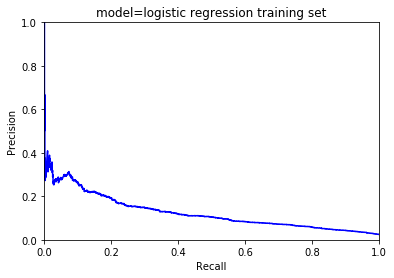

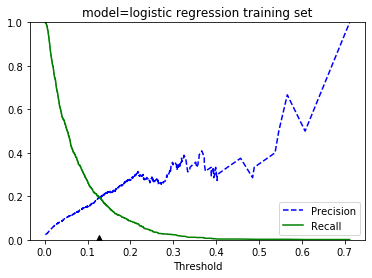

Confusion matrix for threshold = 0.13:
[[33612   692]
 [  693   167]]
Classification report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     34304
           1       0.19      0.19      0.19       860

    accuracy                           0.96     35164
   macro avg       0.59      0.59      0.59     35164
weighted avg       0.96      0.96      0.96     35164



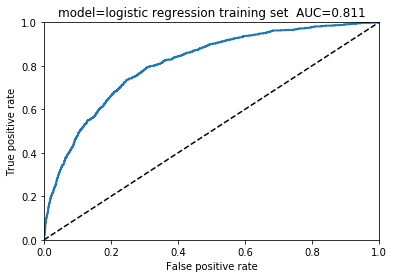

In [104]:
#performance on the training set
exec(open("my_functions.py").read())
probs_train = l1log_reg.predict_proba(X_train)
scores_train = probs_train[:, 1]
train_perf = get_model_performance('logistic regression training set', X_train, scores_train, y_train, pos_label=1)

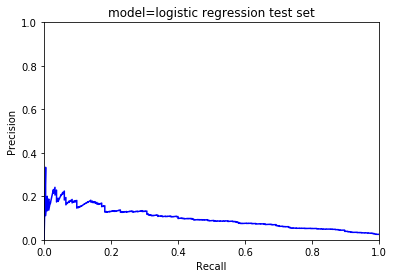

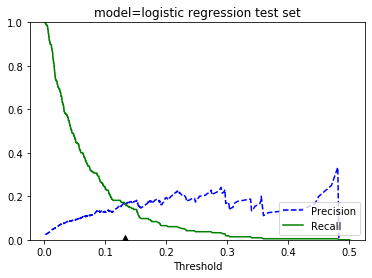

Confusion matrix for threshold = 0.13:
[[8398  179]
 [ 180   35]]
Classification report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      8577
           1       0.16      0.16      0.16       215

    accuracy                           0.96      8792
   macro avg       0.57      0.57      0.57      8792
weighted avg       0.96      0.96      0.96      8792



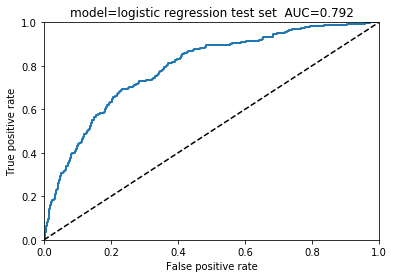

In [105]:
#performance on the test set
probs_test = l1log_reg.predict_proba(X_test)
scores_test = probs_test[:, 1]
test_perf = get_model_performance('logistic regression test set', X_test, scores_test, y_test, pos_label=1)

## regularize features for RF

In [106]:
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.feature_selection import SelectFromModel
sel = SelectFromModel(LogisticRegression(C=1, penalty='l1', solver='liblinear'))
sel.fit(X_train, y_train)
sel.get_support()
print('{} of {} features had nonzero coefficients'.format(np.sum(sel.get_support()), X_train.shape[1]))

X_l1_train = X_train.loc[:, X_train.columns[sel.get_support()]]
X_l1_test = X_test.loc[:, X_test.columns[sel.get_support()]]

89 of 200 features had nonzero coefficients


In [20]:
#------- OPTIMIZE RF
RAND_SEED=321
N_JOBS=3
#use RandomizedSearchCV() to optimized Random forest hyperparameters
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
rf_clf = RandomForestClassifier()

#choose parameter grid values
max_depth = [10, 20, 30, 40, 50]
min_samples_split = [2, 3, 5]
min_samples_leaf = [1, 2, 3]

#make grid dict
random_grid = {'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}


# ### run random search
rf_search = RandomizedSearchCV(estimator = rf_clf,
                               param_distributions = random_grid,
                               n_iter = 100,
                               scoring = 'recall',
                               cv = 5,
                               verbose=2,
                               random_state=RAND_SEED,
                               n_jobs = N_JOBS)
rf_search.fit(X_l1_train, y_train)
best_params = rf_search.best_params_
print(rf_search.best_params_)


Fitting 5 folds for each of 45 candidates, totalling 225 fits


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 45 is smaller than n_iter=100. Running 45 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:   20.8s
[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed:  2.3min
exception calling callback for <Future at 0x7fd888165d10 state=finished raised TerminatedWorkerError>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/_base.py", line 625, in _invoke_call

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker. The exit codes of the workers are {SIGABRT(-6)}

In [98]:
best_params = {'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 20}

In [99]:
#set up optimized rf model based on from best_params above
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
print(best_params)
rf_opt_basic = RandomForestClassifier(n_jobs=N_JOBS,
                                min_samples_split = best_params['min_samples_split'],
                                min_samples_leaf = best_params['min_samples_leaf'],
                                max_depth = best_params['max_depth'],
                                bootstrap = True,
                               random_state=RAND_SEED)

#train
rf_opt_basic.fit(X_l1_train, y_train)

{'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 5}


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=6,
                       oob_score=False, random_state=321, verbose=0,
                       warm_start=False)

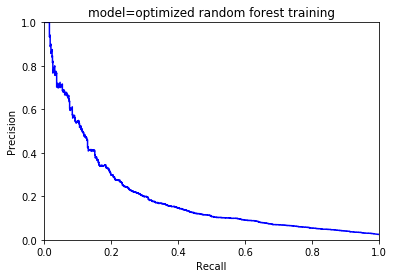

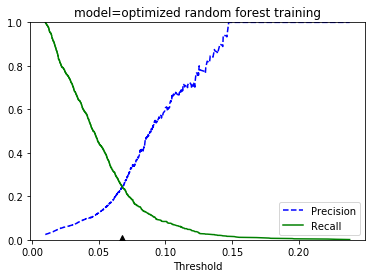

Confusion matrix for threshold = 0.07:
[[34448   663]
 [  664   214]]
Classification report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     35111
           1       0.24      0.24      0.24       878

    accuracy                           0.96     35989
   macro avg       0.61      0.61      0.61     35989
weighted avg       0.96      0.96      0.96     35989



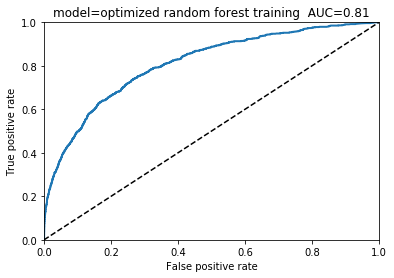

In [100]:
#optimized model performance on training set
scores_opt = rf_opt_basic.predict_proba(X_l1_train)[:, 1]
opt_perf = get_model_performance('optimized random forest training', X_train, scores_opt, y_train, pos_label=1)

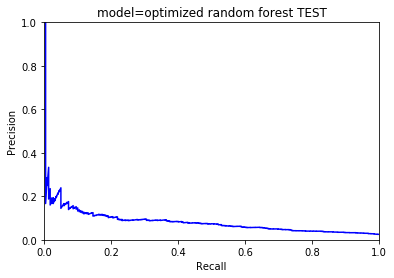

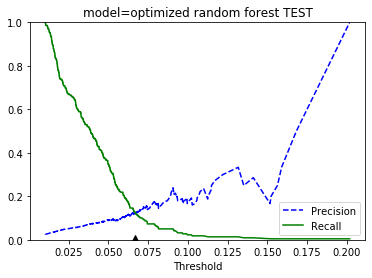

Confusion matrix for threshold = 0.07:
[[8587  192]
 [ 193   26]]
Classification report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      8779
           1       0.12      0.12      0.12       219

    accuracy                           0.96      8998
   macro avg       0.55      0.55      0.55      8998
weighted avg       0.96      0.96      0.96      8998



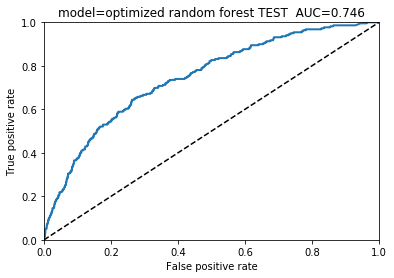

Confusion matrix for threshold = 0.04:
[[7470 1309]
 [ 113  106]]
Classification report:
              precision    recall  f1-score   support

           0       0.99      0.85      0.91      8779
           1       0.07      0.48      0.13       219

    accuracy                           0.84      8998
   macro avg       0.53      0.67      0.52      8998
weighted avg       0.96      0.84      0.89      8998



In [101]:
#predict for test set
test_scores = rf_opt_basic.predict_proba(X_l1_test)[:, 1]
test_perf = get_model_performance('optimized random forest TEST', X_test, test_scores, y_test, pos_label=1)


threshold = 0.04
opt_pred = (test_scores > threshold).astype('int')
y_num = (y_test==1).astype('int')
print('Confusion matrix for threshold = {}:'.format(round(threshold, 2)))
cm = confusion_matrix(y_num, opt_pred)
print(cm)
print('Classification report:')
print(classification_report(y_num, opt_pred))